# Notes on VDF interpolation
___

![illustration](graphics/illustration_nb_interp.png)
___

<code>aidapy</code> VDF utilities are based on the interpolation of the measured VDFs on a user-defined grid. Let's now have a look at what that means, in terms of user inputs, possibilities of the tools, their flexibility, their limits. A few tests are also provided to check the reliability of the interpolation approach, using three different interpolation schemes. This notebook corresponds to Appendices given in [Resonant whistler-electron interactions: MMS observations vs. test-particle simulation](https://arxiv.org/abs/2004.09130)

We will quickly show a binning approach, using some MMS data, to better illustrate the differences between binning and interpolating particle distributions. So let's firtst set up an <code>aidapy</code> environment and load some data (see [this overview notebook](./mms_overview.ipynb) for an introduction on the tools).

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image
import sys, os
import warnings
warnings.filterwarnings('ignore')
from aidapy import load_data
import aidapy.aidaxr
import aidapy.tools.vdf_utils as vdfu
import aidapy.tools.vdf_plot as vplt

start_time = datetime(2019, 3, 8, 13, 54, 53)
end_time   = datetime(2019, 3, 8, 13, 57, 0)

settings = {'prod': ['i_dist', 'e_dist', 'dc_mag', 'sc_att', 'i_bulkv'],
            'probes': ['1'], 'coords': 'gse', 'mode': 'high_res', 'frame':'gse'}

xr_mms = load_data(mission='mms', start_time=start_time, end_time=end_time, **settings)

## Definitions

In one hand, we have measured data, pre-processed by the instrument PI team. In our case, the instrument is the Fast Plasma Investigation, onboard the Magnetospheric MultiScale mission. These data consist of VDF values given over a 3-dimensional grid, the *instrument grid*.

In [2]:
vdf_instr, grid_time, grid_instr_speed, grid_instr_theta, grid_instr_phi,\
nb_vdf, B_gse_par = xr_mms.vdf._preprocess_data('electron')

Coordinates of this grid, which is by nature defined in velocity space, are given by tables provided with the data. These tables tell us, "element with indices $(i,j,k)$ in the VDF data array corresponds to an energy of $E$, a polar angle of $\theta$ and an azimuth angle of $\phi$." We additionaly have a time dimension, and the vector of timestamps is treated just as another grid of coordinates. We can look at the shape of these arrays:

In [3]:
print(vdf_instr.shape)
print(grid_time.shape, grid_instr_speed.shape, grid_instr_theta.shape, grid_instr_phi.shape)

(4234, 32, 16, 32)
(4234,) (32,) (16,) (32,)


These coordinates are given in the *instrument frame*. It is not handy to achieve a scientific analysis in a possibly arbitrary oriented frame of reference. Therefore in many cases, we would like to bring these 4-dimensional data in a physically relevent reference frame. The most common example is a reference frame with one basis vector aligned with the magnetic field. Additionally, it is very convenient to analyse particle data in a frame in which the plasma, composed of electrons and ions, has no bulk velocity. This velocity can often be approximated by the massive ions' bulk velocity. We refer to this B-field aligned, plasma co-moving frame as the *plasma frame* (note that it is still not fully constrained, one orientation - angle around $\mathbf{B}$ - is arbitrary)

To work in the plasma frame, the instrument grid needs to be rotated and shifted. But once rotated and shifted, there is no straightforward way to visualise the VDF values: in one particular frame, we indeed need a regular grid in order to be able to sort out the data and visualise them. Here we are facing two different possibilities to *re-defined* the data over such a regular grid in the plasma frame. The first one is to *bin*, or project the rotated-translated data into a regular grid we define. The second one is to *interpolate* a value at each node of the new grid.

To summarise, we have actual measurements <code>vdf_fpi</code> given over the *instrument grid* <code>grid_time</code>, <code>grid_speed</code>, <code>grid_theta</code>, <code>grid_phi</code>, defined in the *instrument reference frame*. We then define a *grid-of-interest*, expressed in our *reference frame of interest*, the plasma frame here. We consider a rotation matrix $R$ and a translation vector $\mathbf{v}$, defining the transformation from the instrument frame to the plasma frame. In the case of the MMS mission, the FPI particle data are given in the DBCS frame, and we refer to the plasma frame with the index $b$. One can get the time series of rotations matrices:

In [4]:
xr_mms.vdf._init_rotations_matrices(grid_time, start_time, end_time)
R_b_to_dbcs, R_dbcs_to_b = xr_mms.vdf._init_R_b_to_dbcs(grid_time, B_gse_par)

We will first breifly illustrate why the <code>aidapy</code> VDF utilities were designed following on the interpolation approach to the detriment of the binning approach, to then explore and test three different interpolation schemes.


## Binning *vs.* Interpolation

This choice ultimately boiles down to the fact that a binning process may result in significant artifacts.

The binning approach answers to the question "In which cell of the new grid belongs each data point?" While projecting the measurements on the newly defined grid, one cell of that grid may recieve zero, one, or many measurement points. Thus the need to keep track of how many data points end up in which cell. Then, what shall we do with empty cells? Since we deal with an instrument grid which is by nature spherical, and which presents logarithmically spaced points along the energy/speed dimension, such empty cells are unavoidable and will be found in huge amounts for high energies, whereas for low energies the instrument grid resolution is higher than the new binning grid. The following figure illustrates the binning approach.

![illustration](graphics/binning_schem.png)
 
The binning approach has great advantages. The first is its ease of implementation. The second is that it limits the number of operations to the exact number of measurement points, i.e. the size of the instrument grid, which is a great advantage in terms of computation time.

Let's now have a look at the interpolation approach. The game is now to answer the question "Which are the neighbouring data points of one node of the grid-of-interest? How to attribute a value to this node, given these neighbouring data points?". These questions are to some extent similar to the binning question, but are admittedly more complex to answer. This approach immediately shows one invaluable advantage: each and every points of the grid of interest will have a value attributed, without any issue of relative resolution, and most importantly without artifacts due to empty cells.

Instead of transforming the instrument grid to the reference frame of interest, it is much more efficient to do the opposite and bring the grid-of-interest into the instrument frame. This way, when looking for the surrounding neighbours of each grid node, we can take advantage of the fact that the instrument grid in its instrument frame is *regular*, and fast algorithm for interpolating data in N-dimensions on a regular are already implemented in generic scientific libraries.

![illustration](graphics/interp_schem.png)

We still need to choose an interpolation schem: how many neighbours around one particular node do we consider, how do we put weights to the VDF value of these neighbours. <code>aidapy</code> offers three schemes. The first is a nearest-nieghbour scheme, it selects the nearest measurement point and copy its value (one neighbour with weight one). The second is a trilinear interpolation scheme, also implemented in the <code>scipy</code> library. The same <code>scipy</code> method is actually used in the nearest-neighbour and trilinear case, cf. its documentation, [scipy.interpolate.RegularGridInterpolator](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.interpolate.RegularGridInterpolator.html) . The third option is a tricubic interpolation scheme, proposed by [F. Lekien and J. Marsden (2005)](https://doi.org/10.1002/nme.1296) and implemented in the <code>tricubic</code> python package (cf. [PyPi](https://pypi.org/project/tricubic/) and [github](https://github.com/danielguterding/pytricubic)). The [following schematics](https://commons.wikimedia.org/wiki/File:Comparison_of_1D_and_2D_interpolation.svg), used in various wikipedia articles on interpolation, illustrates greatly the difference between the three schemes, in one and two dimensions. Some imagination is required to extend it to the third dimension!

![interp_wikipedia](https://upload.wikimedia.org/wikipedia/commons/9/90/Comparison_of_1D_and_2D_interpolation.svg)

### Interpolating

VDF interpolation is provided by <code>aidapy</code>, which wrapps the above-mentionned interpolation schemes, together with the handling of the frame transformations. 

In [5]:
v_max = 1.2e7
resolution = 50

In [6]:
start_time_sub = datetime(start_time.year, start_time.month, start_time.day, 13, 56, 23, 160000)
end_time_sub   = datetime(start_time.year, start_time.month, start_time.day, 13, 56, 23, 200000)
interp_schem = 'near'
species = 'electron'
frame = 'B'
grid_geom = 'cyl'

xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem)



.____________________________________________________________
| mms_vdf.py, aidapy.
|
| Product(s):
|   - i_dist
|   - e_dist
|   - dc_mag
|   - sc_att
|   - i_bulkv
| Grid geometry:    cyl
| Resolution:       50
| Interpolation:    near
| Start time:       2019-03-08T13:56:23.186320000
| Stop time :       2019-03-08T13:56:23.216320000
| Ind. start-stop:  3006-3007
| Nb distributions: 1
|____________________________________________________________



Total runtime: 0 s.



We have chosen the time so only one VDF was interpolated, as verified by the output. We also find that the one interpolated VDF has the index 3006 in the data. We can use this index for the following binning example.

### Binning

Let's now quickly bin the measured VDF. We first rebuilt the 3-dimensional, spherical instrument grid, and translate it to cartesian coordinates.

In [7]:
grid_instr_spher = np.ones((3,32,16,32))
grid_instr_spher[0] *= grid_instr_speed[:, None, None]
grid_instr_spher[1] *= grid_instr_theta[None, :, None]
grid_instr_spher[2] *=   grid_instr_phi[None, None, :]
grid_instr_cart = -1.*vdfu.spher2cart(grid_instr_spher)

***Note!***: <code>grid_instr_cart</code> are coordinates expressed in a cartesian *system of coordinates*, i.e. $(v_x, v_y, v_z)$, but its *geometry* is still spherical!

We then rotate this grid in order to align its $v_z$-axis with the local magnetic field. The rotation matrices are provided in <code>R_dbcs_to_b</code>, as shown previously. We get <code>grid_B</code>, which we then express as a 2-dimensional grid, <code>grid_par_per</code>, corresponding to the 2-dimensional $(v_{para}, v_{perp})$-plane.

In [8]:
#grid_inst_cart -= v0[:,None,None,None]
iS = 3006
grid_B = np.dot(R_dbcs_to_b[iS], grid_instr_cart.reshape(3,-1)).reshape(grid_instr_spher.shape)
grid_par_per = np.zeros((2,32,16,32))
grid_par_per[0] = grid_B[2]
grid_par_per[1] = np.sqrt(grid_B[0]**2+grid_B[1]**2)

And finally the actual binning is done, using the [<code>numpy.histogram2d</code>](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html) method.

In [9]:
bins_par = np.linspace(-v_max, v_max, resolution+1)
bins_per = np.linspace(0., v_max, int(resolution/2.)+1)
c0, xb, yb = np.histogram2d(grid_par_per[0].flatten(), grid_par_per[1].flatten(),
                            bins=[bins_par,bins_per], weights=np.ones_like(vdf_instr[iS]).flatten())

Now let's plot and compare the two results.

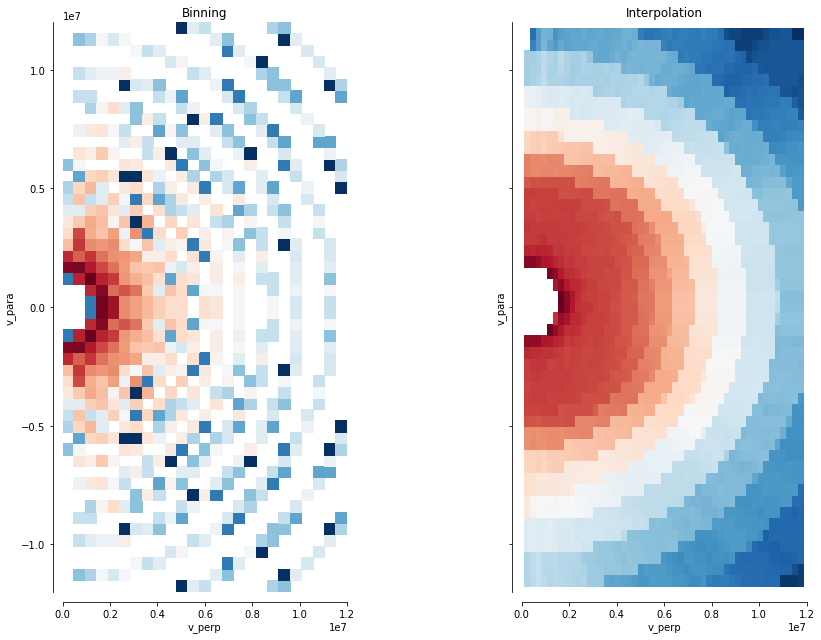

In [10]:
fig, AX = plt.subplots(1, 2, figsize=(14,9), sharex=True, sharey=True)
for ax in AX:
    ax.set_aspect('equal')
    ax.set_xlabel('v_perp')
    ax.set_ylabel('v_para')

AX[0].pcolormesh(bins_per, bins_par, np.log10(c0),
                 #vmin=-19, vmax=-13,
                 cmap='RdBu_r', rasterized=True)
x = xr_mms['grid_interp_cyl'][0,:,0,0]
y = xr_mms['grid_interp_cyl'][2,0,0,:]
AX[0].set_title('Binning')

AX[1].pcolormesh(x, y, np.log10(xr_mms['vdf_interp_time'])[0].T,
                cmap='RdBu_r', rasterized=True)
AX[1].set_title('Interpolation')

vplt.set_spines(AX)
plt.tight_layout()
plt.show()

As discussed previously, the binning shows dramatic artifacts. The interpolation was set-up for using a nearest-neighbour scheme, and so for medium to high energies, we actually can recognise the instrument energy bins as flat steps.

Let's try to higher the resolution and re-run the two processes, using now a cubic interpolation.

In [11]:
resolution = 180

In [12]:
bins_par = np.linspace(-v_max, v_max, resolution+1)
bins_per = np.linspace(0., v_max, int(resolution/2.)+1)
c0, xb, yb = np.histogram2d(grid_par_per[0].flatten(), grid_par_per[1].flatten(),
                            bins=[bins_par,bins_per], weights=np.ones_like(vdf_instr[iS]).flatten())

In [13]:
interp_schem = 'cub'

xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem)



.____________________________________________________________
| mms_vdf.py, aidapy.
|
| Product(s):
|   - i_dist
|   - e_dist
|   - dc_mag
|   - sc_att
|   - i_bulkv
| Grid geometry:    cyl
| Resolution:       180
| Interpolation:    cub
| Start time:       2019-03-08T13:56:23.186320000
| Stop time :       2019-03-08T13:56:23.216320000
| Ind. start-stop:  3006-3007
| Nb distributions: 1
|____________________________________________________________



Total runtime: 10 s.



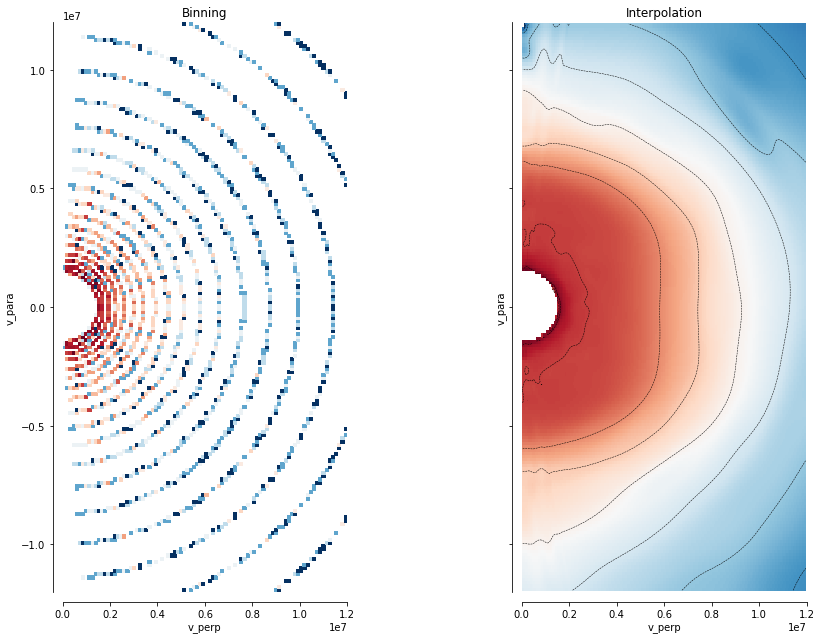

In [14]:
fig, AX = plt.subplots(1, 2, figsize=(14,9), sharex=True, sharey=True)
for ax in AX:
    ax.set_aspect('equal')
    ax.set_xlabel('v_perp')
    ax.set_ylabel('v_para')

AX[0].pcolormesh(bins_per, bins_par, np.log10(c0),
                 #vmin=-19, vmax=-13,
                 cmap='RdBu_r', rasterized=True)
x = xr_mms['grid_interp_cyl'][0,:,0,0]
y = xr_mms['grid_interp_cyl'][2,0,0,:]
AX[0].set_title('Binning')

AX[1].pcolormesh(x, y, np.log10(xr_mms['vdf_interp_time'])[0].T,
                cmap='RdBu_r', rasterized=True)
AX[1].contour(x, y, np.log10(xr_mms['vdf_interp_time'])[0].T, 10,
              colors='k', linewidths=.5)
AX[1].set_title('Interpolation')


vplt.set_spines(AX)
plt.tight_layout()
plt.show()

For this resolution, the binned result is unusable. The tricubic interpolation displays an extremely smooth result and one can already see some very interesting aspect of this precise VDF, studied in more details in a [dedicated notebook](./whistler_cyclotron.ipynb).


## Testing the interpolations

We will now have a closer look at the results of the interpolation method, and design some tests for it.

### 1-dimensional profile: measurement vs. interpolation

In [15]:
interp_schem = 'near'
grid_geom = 'spher'
frame = 'instrument'

xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem)



.____________________________________________________________
| mms_vdf.py, aidapy.
|
| Product(s):
|   - i_dist
|   - e_dist
|   - dc_mag
|   - sc_att
|   - i_bulkv
| Grid geometry:    spher
| Resolution:       180
| Interpolation:    near
| Start time:       2019-03-08T13:56:23.186320000
| Stop time :       2019-03-08T13:56:23.216320000
| Ind. start-stop:  3006-3007
| Nb distributions: 1
|____________________________________________________________



Total runtime: 0 s.



In [16]:
vdf_interp = xr_mms['vdf_interp']
grid_spher = xr_mms['grid_interp_spher'].values
grid_speed = grid_spher[0, :, 0, 0]
grid_theta = grid_spher[1, 0, :, 0]
grid_phi   = grid_spher[2, 0, 0, :]
grid_instr_theta = np.pi-grid_instr_theta
grid_instr_phi = (grid_instr_phi+np.pi)%(2.*np.pi)

In [17]:
print(grid_instr_theta[8], grid_instr_phi[0])
print(grid_theta[84], grid_phi[92])
profile_instr = vdf_instr[3006,:,8,0]
profile_interp_near = vdf_interp[:,84,92]

1.4726217 3.2354043
1.4748032 3.228859


In [18]:
interp_schem = 'lin'

xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem)
vdf_interp = xr_mms['vdf_interp']
profile_interp_lin = vdf_interp[:,84,92]



.____________________________________________________________
| mms_vdf.py, aidapy.
|
| Product(s):
|   - i_dist
|   - e_dist
|   - dc_mag
|   - sc_att
|   - i_bulkv
| Grid geometry:    spher
| Resolution:       180
| Interpolation:    lin
| Start time:       2019-03-08T13:56:23.186320000
| Stop time :       2019-03-08T13:56:23.216320000
| Ind. start-stop:  3006-3007
| Nb distributions: 1
|____________________________________________________________



Total runtime: 1 s.



In [19]:
interp_schem = 'cub'

xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem)
vdf_interp = xr_mms['vdf_interp']
profile_interp_cub = vdf_interp[:,84,92]



.____________________________________________________________
| mms_vdf.py, aidapy.
|
| Product(s):
|   - i_dist
|   - e_dist
|   - dc_mag
|   - sc_att
|   - i_bulkv
| Grid geometry:    spher
| Resolution:       180
| Interpolation:    cub
| Start time:       2019-03-08T13:56:23.186320000
| Stop time :       2019-03-08T13:56:23.216320000
| Ind. start-stop:  3006-3007
| Nb distributions: 1
|____________________________________________________________



Total runtime: 12 s.



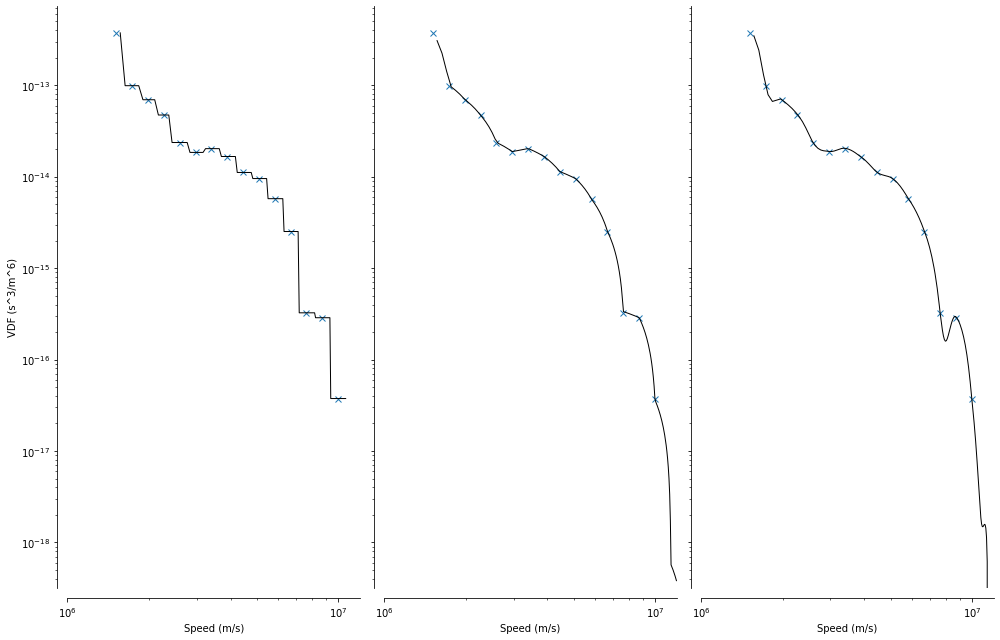

In [20]:
profile_instr = vdf_instr[3006,:,8,0]
profile_interp_near[profile_interp_near==0.] = np.nan
profile_interp_lin[profile_interp_lin==0.] = np.nan
profile_interp_cub[profile_interp_cub==0.] = np.nan

fig, AX = plt.subplots(1, 3, figsize=(14,9), sharey=True, sharex=True)

AX[0].plot(grid_instr_speed, profile_instr, 'x')
AX[0].plot(grid_speed, profile_interp_near, 'k', lw=1)

AX[1].plot(grid_instr_speed, profile_instr, 'x')
AX[1].plot(grid_speed, profile_interp_lin, 'k', lw=1)

AX[2].plot(grid_instr_speed, profile_instr, 'x')
AX[2].plot(grid_speed, profile_interp_cub, 'k', lw=1)

for ax in AX:
    ax.set_xlim([1e6, 1.2e7])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Speed (m/s)')
AX[0].set_ylabel('VDF (s^3/m^6)')

vplt.set_spines(AX)
plt.tight_layout()
plt.show()

### 2-dimensional error maps

In [21]:
def maxwellian_3D(vx, vy, vz, A, v_th, vbx=0., vby=0., vbz=0.):
    '''
    Return distribution function at (vx, vy, vz),
    given 6 distribution parameters.
    '''
    # Put in bulk frame
    vx = vx - vbx
    vy = vy - vby
    vz = vz - vbz
    exponent = (vx**2 + vy**2 + vz**2)/v_th**2 #+ (vy/vth)**2 + (vz/vth)**2

    return A * np.exp(-exponent)

In [22]:
v_b = 1.*np.array([0., 1.e6, 1.e6])
vdf_maxw = maxwellian_3D(grid_instr_cart[0], grid_instr_cart[1], grid_instr_cart[2],
                         1.e-13, 6.e6, *v_b)
xr_mms['e_dist1'][3006] = np.swapaxes(vdf_maxw, 0, 2)*1e-12

In [23]:
xr_mms['dc_mag1'][:,2] *= 0. # Artificially rotating the B-field, to mis-align it with SC axis.
interp_schem = 'near'
#frame = 'B'
frame = 'instrument'
xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem, verbose=False)
vdf_near = xr_mms['vdf_interp'].values
vdf_interp = xr_mms['vdf_interp'].values
profile_interp_near = vdf_interp[:,84,92]

interp_schem = 'lin'
xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem, verbose=False)
vdf_lin = xr_mms['vdf_interp'].values
vdf_interp = xr_mms['vdf_interp'].values
profile_interp_lin = vdf_interp[:,84,92]

interp_schem = 'cub'
xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
                                species=species, frame=frame, grid_geom=grid_geom,
                                v_max=v_max, resolution=resolution, interp_schem=interp_schem, verbose=False)
vdf_cub = xr_mms['vdf_interp'].values
vdf_interp = xr_mms['vdf_interp'].values
profile_interp_cub = vdf_interp[:,84,92]

In [24]:
grid_interp_cart = xr_mms['grid_interp_cart'].values
v_b = 1.*np.array([0., 1e6, 1.e6])
vdf_maxw = maxwellian_3D(grid_interp_cart[0], grid_interp_cart[1], grid_interp_cart[2],
                         1.e-13, 6.e6, *v_b)

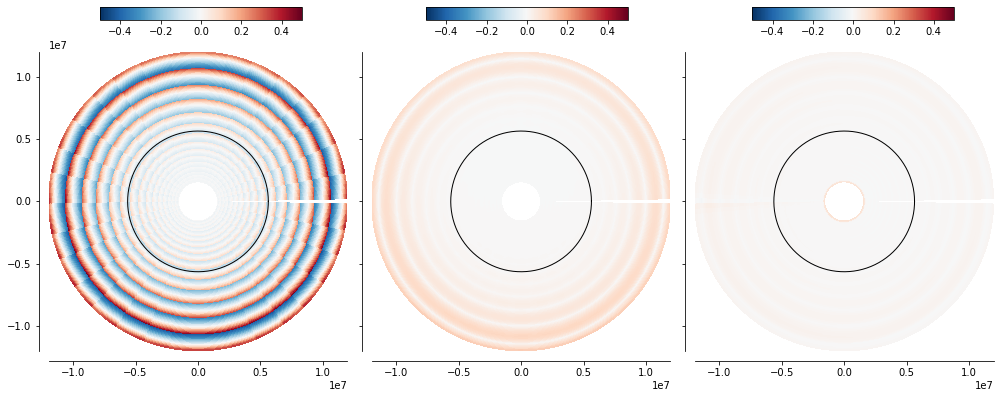

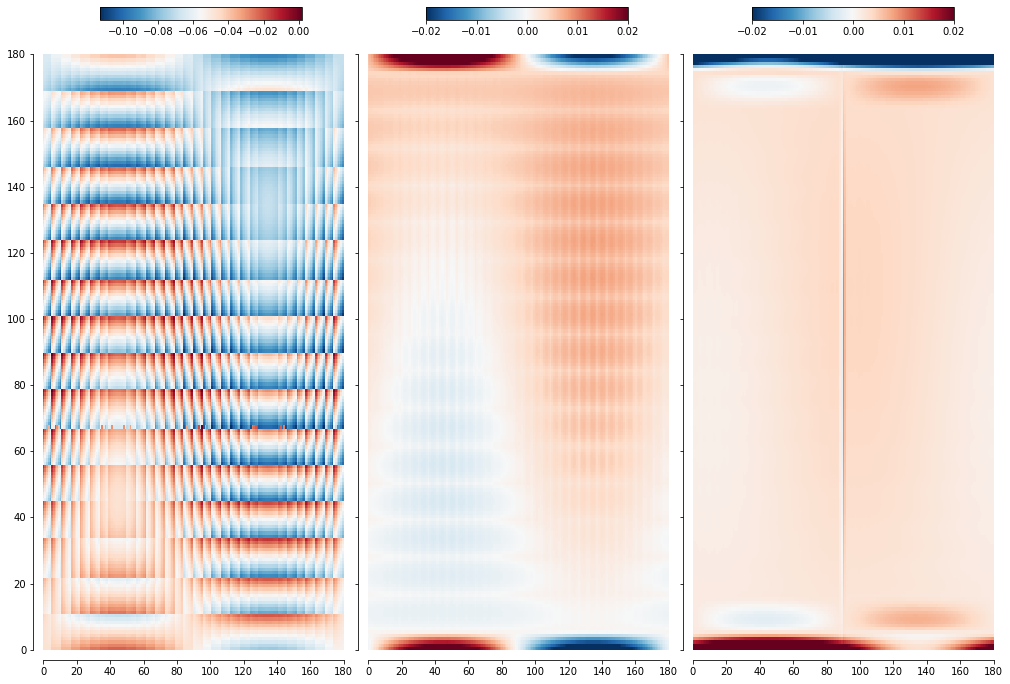

In [26]:
vdf_instr, grid_time, grid_instr_speed, grid_instr_theta, grid_instr_phi,\
nb_vdf, B_gse_par = xr_mms.vdf._preprocess_data('electron')
profile_instr = vdf_instr[3006,:,8,0]
profile_interp_near[profile_interp_near==0.] = np.nan
profile_interp_lin[profile_interp_lin==0.] = np.nan
profile_interp_cub[profile_interp_cub==0.] = np.nan
profile_analytical = np.nanmean(vdf_maxw, axis=(1,2))

grid_interp_spher = xr_mms['grid_interp_spher'].values

vdf_near[vdf_near==0.] = np.nan
vdf_lin[vdf_lin==0.] = np.nan
vdf_cub[vdf_cub==0.] = np.nan
err_near = (vdf_near-vdf_maxw)/vdf_maxw
err_lin  = (vdf_lin -vdf_maxw)/vdf_maxw
err_cub  = (vdf_cub -vdf_maxw)/vdf_maxw

ind_mid = int(resolution/2.)

fig, AX = plt.subplots(1, 3, figsize=(14,9), sharey=True, sharex=True)
for ax in AX: ax.set_aspect('equal')

vlim = .5
AX[0].pcolormesh(grid_interp_cart[0,:,ind_mid,:], grid_interp_cart[1,:,ind_mid,:], err_near[:,ind_mid],
                 vmin=-vlim, vmax=vlim,
                 cmap='RdBu_r', rasterized=True)

AX[1].pcolormesh(grid_interp_cart[0,:,ind_mid,:], grid_interp_cart[1,:,ind_mid,:], err_lin[:,ind_mid],
                 vmin=-vlim, vmax=vlim,
                 cmap='RdBu_r', rasterized=True)

m2 = AX[2].pcolormesh(grid_interp_cart[0,:,ind_mid,:], grid_interp_cart[1,:,ind_mid,:], err_cub[:,ind_mid],
                      vmin=-vlim, vmax=vlim,
                      cmap='RdBu_r', rasterized=True)

e_level = 84
rr = grid_interp_spher[0,e_level,0,0]
tt = np.linspace(0,2.*np.pi,400)
for ax in AX:
    ax.plot(rr*np.cos(tt), rr*np.sin(tt), 'k', lw=1)

posAx = AX[0].get_position()
cax = fig.add_axes([posAx.x1-.25, posAx.y1+.1, .2, 0.02])
cb = fig.colorbar(m2, cax=cax, orientation='horizontal')
posAx = AX[1].get_position()
cax = fig.add_axes([posAx.x1-.2, posAx.y1+.1, .2, 0.02])
cb = fig.colorbar(m2, cax=cax, orientation='horizontal')
posAx = AX[2].get_position()
cax = fig.add_axes([posAx.x1-.15, posAx.y1+.1, .2, 0.02])
cb = fig.colorbar(m2, cax=cax, orientation='horizontal')
#cb.set_ticks([-1,0,1])

vplt.set_spines(AX)
plt.tight_layout()
plt.show()

fig, AX = plt.subplots(1, 3, figsize=(14,9), sharey=True, sharex=True)
vlim=.02
m0 = AX[0].pcolormesh(err_near[e_level],
                      #vmin=-vlim, vmax=vlim,
                      cmap='RdBu_r', rasterized=True)

m1 = AX[1].pcolormesh(err_lin[e_level],
                      vmin=-vlim, vmax=vlim,
                      cmap='RdBu_r', rasterized=True)

m2 = AX[2].pcolormesh(err_cub[e_level],
                      vmin=-vlim, vmax=vlim,
                      cmap='RdBu_r', rasterized=True)

posAx = AX[0].get_position()
cax = fig.add_axes([posAx.x1-.25, posAx.y1+.15, .2, 0.02])
cb = fig.colorbar(m0, cax=cax, orientation='horizontal')
posAx = AX[1].get_position()
cax = fig.add_axes([posAx.x1-.2, posAx.y1+.15, .2, 0.02])
cb = fig.colorbar(m1, cax=cax, orientation='horizontal')
posAx = AX[2].get_position()
cax = fig.add_axes([posAx.x1-.15, posAx.y1+.15, .2, 0.02])
cb = fig.colorbar(m2, cax=cax, orientation='horizontal')
#cb.set_ticks([-1,0,1])

vplt.set_spines(AX)
plt.tight_layout()
plt.show()